# Jonathan Halverson
# Tuesday, December 5, 2017
# Speech recognition: "Yes" versus "Nine"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
from scipy.io import wavfile

f = 'datasets/speech_commands_v0.01/yes/0a7c2a8d_nohash_0.wav'
f = 'datasets/speech_commands_v0.01/eight/3a70ab7f_nohash_0.wav'
f = 'datasets/speech_commands_v0.01/marvin/4a4e28f1_nohash_0.wav'
f = 'datasets/speech_commands_v0.01/marvin/5a9f7324_nohash_0.wav' # low freq
f = 'datasets/speech_commands_v0.01/marvin/6a861f21_nohash_0.wav' # high freq
sample_rate, data = wavfile.read(f) # 16-bit  PCM  -32768  +32767  int16
times = np.arange(data.size) / float(sample_rate)

How many samples per second are there?

In [3]:
sample_rate

16000

What do the first ten values look like?

In [4]:
data[:10]

array([ 1,  3,  3,  1,  0,  0,  0,  0,  0, -1], dtype=int16)

How many samples are there?

In [5]:
data.size

16000

How many unique values are there?

In [6]:
np.unique(data).size

7259

What are the min, mean and max values?

In [7]:
data.min(), data.mean(), data.max()

(-28099, -0.20075000000000001, 32767)

In [8]:
2**16 - 0.5 * 2**16 # 16-bit  PCM  -32768  +32767  int16

32768.0

Here is the waveform:

(-32768, 32768)

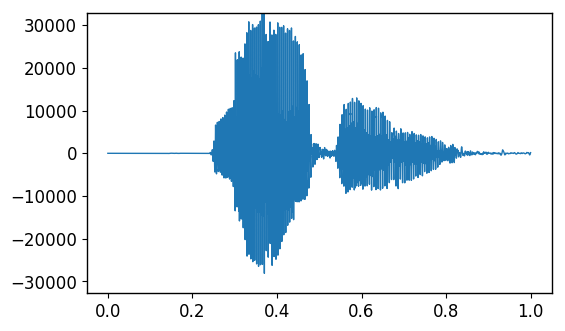

In [9]:
plt.plot(times, data)
plt.ylim(-2**15, 2**15)

(-32768, 32768)

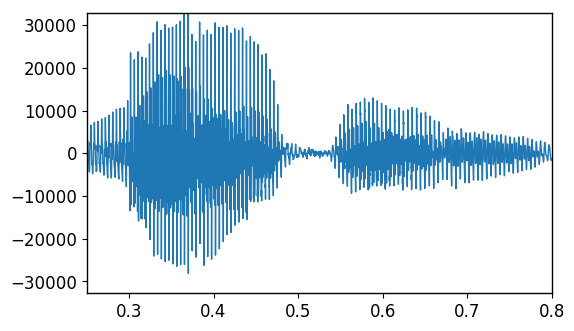

In [10]:
plt.plot(times, data)
plt.xlim(0.25, 0.8)
plt.ylim(-2**15, 2**15)

Here is 1/100 of second in the middle:

(-32768, 32768)

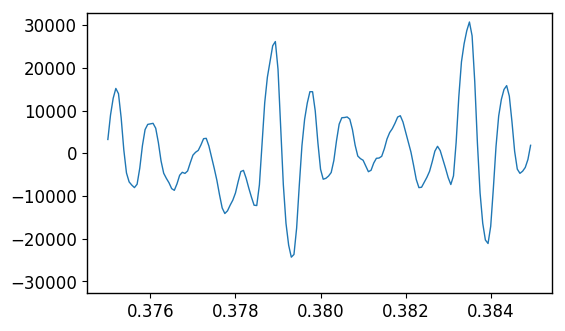

In [11]:
plt.plot(np.arange(6000, 6160) / float(sample_rate), data[6000:6160])
plt.ylim(-2**15, 2**15)

### Let's make a spectrogram manually

The idea is to compute the DFT within a set of overlapping windows:

In [12]:
from numpy import fft

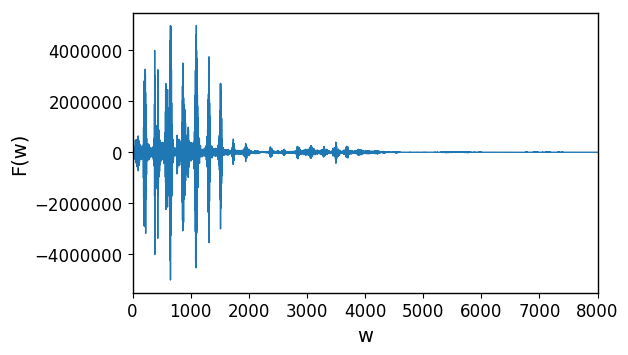

In [13]:
plt.plot(np.arange(data.size), fft.fft(data).real)
plt.xlim(0, 8000)
plt.xlabel('w')
plt.ylabel('F(w)')

In [14]:
samples_per_chunk = 160
chunks = data.size / samples_per_chunk
chunks

100

In [15]:
acc = []
for chunk in range(chunks):
     output = fft.fft(data[chunk * samples_per_chunk:(chunk + 1) * samples_per_chunk]).real
     acc.append(np.where(output[0:8000] >= 0.0, output[0:8000], 0.0))

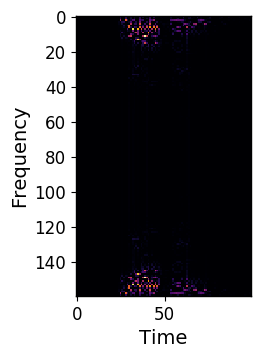

In [16]:
plt.imshow(np.array(acc).T, cmap='inferno', interpolation='none')
plt.xlabel('Time')
plt.ylabel('Frequency')

### Below we use SciPy to compute the spectrogram:

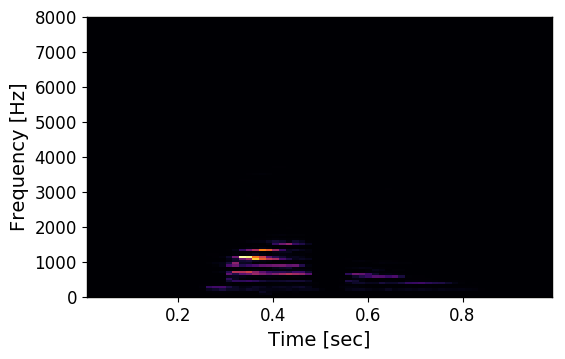

In [17]:
from scipy import signal

sample_rate, samples = wavfile.read(f)
assert sample_rate == 16000
assert samples.size == 16000
frequencies, times, spectrogram = signal.spectrogram(samples, fs=sample_rate, window=('tukey', 0.25))

plt.pcolormesh(times, frequencies, spectrogram, cmap='inferno')
plt.ylim(0, 8e3)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

The figure below is what we will be working with:

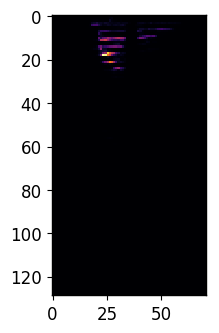

In [18]:
# spectrogram[::-1,] to invert vertically
plt.imshow(spectrogram / spectrogram.max(), cmap='inferno', interpolation='none')

In [19]:
height, width = spectrogram.shape
height, width

(129, 71)

In [20]:
type(spectrogram), spectrogram.dtype

(numpy.ndarray, dtype('float32'))

In [21]:
spectrogram.min(), spectrogram.mean(), spectrogram.max()

(6.7560459e-09, 2645.7983, 654511.19)

### Prepare the data for Tensorflow

In [22]:
import glob

In [23]:
yes = glob.glob('datasets/speech_commands_v0.01/yes/*.wav')
nine = glob.glob('datasets/speech_commands_v0.01/nine/*.wav')

Shuffle the paths and labels:

In [24]:
paths = np.array(yes + nine)
labels = np.append(np.zeros(len(yes), dtype=np.int32), [np.ones(len(nine), dtype=np.int32)])
indices = np.arange(paths.size)
np.random.shuffle(indices)

In [25]:
paths = paths[indices]
labels = labels[indices]

In [26]:
np.bincount(labels)

array([2377, 2364])

Remove samples which are not 1 second long and recorded at 16 kHz:

In [27]:
clean_paths = []
clean_labels = []
for path, label in zip(paths, labels):
     sample_rate, samples = wavfile.read(path)
     if (sample_rate == 16000) and (samples.size == 16000):
          clean_paths.append(path)
          clean_labels.append(label)
paths = np.array(clean_paths)
labels = np.array(clean_labels)

In [28]:
np.bincount(labels)

array([2157, 2174])

Create a train-test split:

In [29]:
train_size = 0.8
thres = int(paths.size * train_size)
train_paths = paths[:thres]
train_labels = labels[:thres]
test_paths = paths[thres:]
test_labels = labels[thres:]

In [30]:
def fetch_batch(sound_paths, sound_labels, batch_size=25):
     indices = np.random.choice(np.arange(sound_paths.size), size=batch_size, replace=False)
     acc = []
     for path in sound_paths[indices]:
          sample_rate, samples = wavfile.read(path)
          frequencies, times, spectrogram = signal.spectrogram(samples, fs=sample_rate)
          acc.append(spectrogram / spectrogram.max()) # scale to [0, 1]
     return np.array(acc), sound_labels[indices]

In [31]:
X_test, y_test = fetch_batch(test_paths, test_labels, batch_size=test_paths.size)
X_test.shape

(867, 129, 71)

In [32]:
ind_0 = np.argwhere(y_test == 0).flatten()
ind_1 = np.argwhere(y_test == 1).flatten()

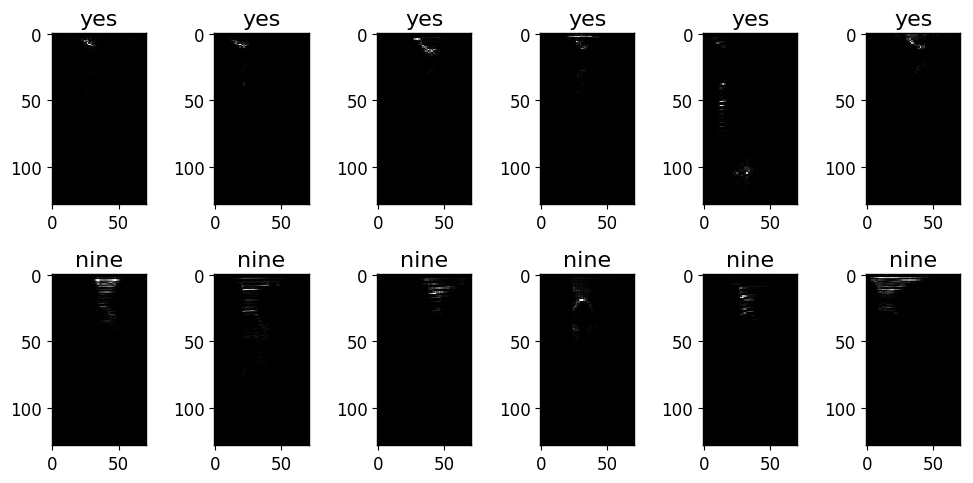

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(10, 5))
for j in range(6):
     ax[0, j].imshow(X_test[ind_0[j]], cmap='gray', interpolation='none')
     ax[0, j].set_title('yes')
for j in range(6):
     ax[1, j].imshow(X_test[ind_1[j]], cmap='gray', interpolation='none')
     ax[1, j].set_title('nine')
fig.tight_layout()

### Check the sigmoid function in TF

In [34]:
import tensorflow as tf

In [35]:
tf.reset_default_graph()

In [36]:
x = tf.constant(np.linspace(-5, 5, num=250))
y = tf.sigmoid(x)

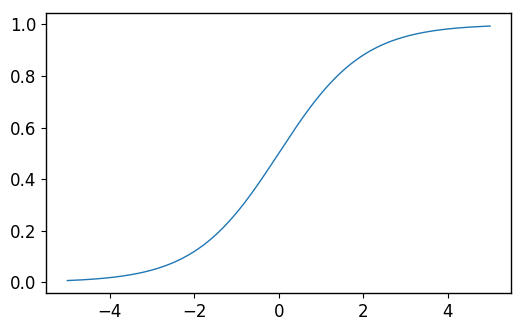

In [37]:
with tf.Session() as sess:
     plt.plot(x.eval(), y.eval())

### Train a CNN in tensorflow

In [38]:
tf.reset_default_graph()

In [39]:
with tf.name_scope('inputs'):
     X = tf.placeholder(dtype=tf.float32, shape=(None, height, width), name="X")
     X_reshaped = tf.reshape(X, shape=(-1, height, width, 1))
     y = tf.placeholder(dtype=tf.int32, shape=(None), name="y")

In [40]:
conv1_fmaps = 10
conv2_fmaps = 20

In [41]:
conv_1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=3, strides=[1, 1], padding="SAME", activation=tf.nn.relu)
max_pool_1 = tf.nn.max_pool(conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
conv_2 = tf.layers.conv2d(max_pool_1, filters=conv2_fmaps, kernel_size=2, strides=[2, 2], padding="SAME", activation=tf.nn.relu)
max_pool_2 = tf.nn.max_pool(conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

with tf.name_scope("fc1"):
     max_pool_2_flat = tf.reshape(max_pool_2, shape=[-1, conv2_fmaps * 16 *  9])
     full_1 = tf.layers.dense(max_pool_2_flat, units=50, activation=tf.nn.relu)

with tf.name_scope("output"):
     prob_positive = tf.layers.dense(full_1, units=1, activation=tf.sigmoid, name='outputs')

In [42]:
with tf.name_scope('loss'):
     loss = tf.losses.log_loss(labels=y, predictions=prob_positive)

In [43]:
learning_rate = 0.01
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.95, use_nesterov=True)
training_op = optimizer.minimize(loss)

In [44]:
with tf.name_scope('my_metrics'):
     thres = 0.5
     y_pred = tf.cast(prob_positive > thres, tf.int32)
     cm = tf.confusion_matrix(labels=y, predictions=y_pred, num_classes=2, dtype=tf.float64)
     accuracy = tf.trace(cm) / tf.reduce_sum(cm)

In [45]:
init = tf.global_variables_initializer()

In [46]:
batch_size = 200
n_epochs = 1

In [47]:
with tf.Session() as sess:
     init.run()
     for epoch in xrange(n_epochs + 1):
          for iteration in range(train_paths.size // batch_size):
               X_batch, y_batch = fetch_batch(train_paths, train_labels, batch_size)
               #print max_pool_2.shape
               sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
          if (epoch % 10 == 0):
               print epoch, "train:", accuracy.eval(feed_dict={X:X_batch, y:y_batch})
               print "Test:", accuracy.eval(feed_dict={X:X_test, y:y_test})

0 train: 0.49
Test: 0.462514417532


### Let's try a simple model based on the sum of values in each spectrogram

In [48]:
X_train, y_train = fetch_batch(train_paths, train_labels, batch_size=train_paths.size)

In [49]:
spectrogram_sum = np.array([spectrogram.sum() for spectrogram in X_train])

In [50]:
np.corrcoef(spectrogram_sum, y_train)

array([[ 1.        ,  0.57315824],
       [ 0.57315824,  1.        ]])

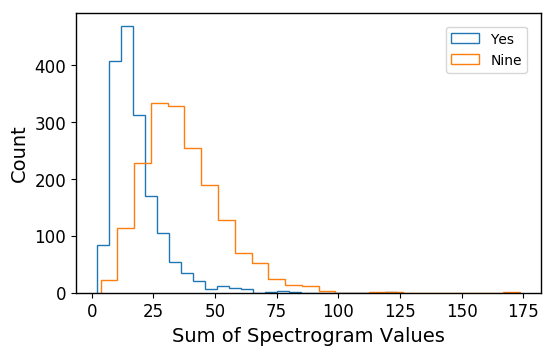

In [51]:
plt.hist(spectrogram_sum[y_train == 0], bins=25, histtype='step', label='Yes')
plt.hist(spectrogram_sum[y_train == 1], bins=25, histtype='step', label='Nine')
plt.legend()
plt.xlabel('Sum of Spectrogram Values')
plt.ylabel('Count')

In [52]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
X = spectrogram_sum.reshape(-1, 1)
print lr.fit(X, y_train).score(X, y_train)

0.796766743649


We see that we achieve 79% accuracy on the train data when the sum of the spectrogram values is used as the only feature.

### Fully connected DNN

Let's try using the same features as the CNN but this time with a fully connected DNN:

In [53]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/Users/jhalverson/scikit_learn_data/mldata/')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /Users/jhalverson/scikit_learn_data/mldata/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /Users/jhalverson/scikit_learn_data/mldata/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /Users/jhalverson/scikit_learn_data/mldata/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /Users/jhalverson/scikit_learn_data/mldata/t10k-labels-idx1-ubyte.gz


In [54]:
digits_test = mnist.test.images.copy()
labels_test = mnist.test.labels.copy()

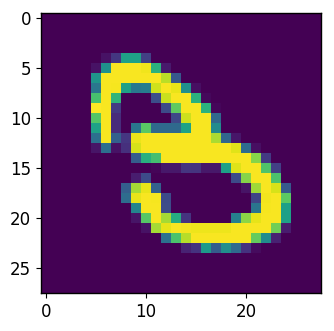

In [55]:
X_test = digits_test[(labels_test == 3) | (labels_test == 9)]
y_test = labels_test[(labels_test == 3) | (labels_test == 9)]
X_test = X_test.reshape(-1, 28, 28)
y_test[y_test == 3] = 0
y_test[y_test == 9] = 1

plt.imshow(X_test[4])

In [56]:
digits = mnist.train.images.copy()
labels = mnist.train.labels.copy()

In [57]:
digits[0].shape

(784,)

In [58]:
np.bincount(labels)

array([5444, 6179, 5470, 5638, 5307, 4987, 5417, 5715, 5389, 5454])

In [59]:
d3 = digits[labels == 3]
d9 = digits[labels == 9]
l3 = np.zeros(d3.shape[0], dtype=np.int32)
l9 = np.ones(d9.shape[0], dtype=np.int32)

d39 = np.append(d3, d9, axis=0)
l39 = np.append(l3, l9)

indices = np.arange(l39.size)
np.random.shuffle(indices)
d39 = d39[indices]
l39 = l39[indices]

In [60]:
d39.shape, l39.shape

((11092, 784), (11092,))

In [61]:
width, height = 28, 28

In [62]:
def fetch_digits(batch_size=20):
     indices = np.random.choice(np.arange(l39.size), size=batch_size, replace=False)
     return d39[indices].reshape(-1, width, height), l39[indices].astype(np.int32)

In [63]:
xx, yy = fetch_digits(2000)
xx.shape, yy.shape

((2000, 28, 28), (2000,))

### Try logistic regression

In [64]:
lr.fit(xx.reshape(-1, width * height), yy).score(xx.reshape(-1, width * height), yy)

0.99750000000000005

### Construct fully connected deep neural network

In [65]:
tf.reset_default_graph()

In [66]:
with tf.name_scope('inputs'):
     X = tf.placeholder(dtype=tf.float32, shape=(None, height, width), name="X")
     X_reshaped = tf.reshape(X, shape=(-1, height * width))
     y = tf.placeholder(dtype=tf.int32, shape=(None), name="y")

In [67]:
with tf.name_scope("fc1"):
     fc_1 = tf.layers.dense(X_reshaped, units=100, activation=tf.nn.elu)
     fc_2 = tf.layers.dense(fc_1, units=100, activation=tf.nn.elu)
     fc_3 = tf.layers.dense(fc_2, units=100, activation=tf.nn.elu)
     fc_4 = tf.layers.dense(fc_3, units=100, activation=tf.nn.elu)
     prob_positive = tf.layers.dense(fc_4, units=1, activation=tf.sigmoid, name='output')

In [68]:
with tf.name_scope('loss'):
     loss = tf.losses.log_loss(labels=y, predictions=prob_positive)

In [69]:
learning_rate = 0.001
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.95, use_nesterov=True)
training_op = optimizer.minimize(loss)

In [70]:
with tf.name_scope('my_metrics'):
     thres = 0.5
     y_pred = tf.cast(prob_positive > thres, tf.int32)
     cm = tf.confusion_matrix(labels=y, predictions=y_pred, num_classes=2, dtype=tf.float64)
     accuracy = tf.trace(cm) / tf.reduce_sum(cm)

In [71]:
init = tf.global_variables_initializer()

In [80]:
batch_size = 50
n_epochs = 500

In [81]:
with tf.Session() as sess:
     init.run()
     for epoch in xrange(n_epochs + 1):
          #for iteration in range(train_paths.size // batch_size):
          for iteration in range(d39.shape[0] // batch_size):
               X_batch, y_batch = fetch_digits(batch_size)
               #X_batch, y_batch = fetch_batch(train_paths, train_labels, batch_size)
               sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
          if (epoch % 10 == 0):
               print epoch, "----------"
               print "Train:", accuracy.eval(feed_dict={X:X_batch, y:y_batch})
               print "Test:", accuracy.eval(feed_dict={X:X_test, y:y_test})
               print "Loss:", loss.eval(feed_dict={X:X_test, y:y_test})

0 ----------
Train: 0.56
Test: 0.506686478455
Loss: 0.698437
10 ----------
Train: 0.58
Test: 0.55720653789
Loss: 0.694445
20 ----------
Train: 0.86
Test: 0.835066864785
Loss: 0.69346
30 ----------
Train: 0.38
Test: 0.502724120852
Loss: 0.695163
40 ----------
Train: 0.9
Test: 0.882119861317
Loss: 0.693434
50 ----------
Train: 0.94
Test: 0.891035165924
Loss: 0.6935
60 ----------
Train: 0.4
Test: 0.524021792967
Loss: 0.693936
70 ----------
Train: 0.66
Test: 0.502724120852
Loss: 0.694717
80 ----------
Train: 0.9
Test: 0.877662209014
Loss: 0.693398
90 ----------
Train: 0.82
Test: 0.880633977216
Loss: 0.693369
100 ----------
Train: 0.6
Test: 0.512630014859
Loss: 0.694084
110 ----------
Train: 0.92
Test: 0.908370480436
Loss: 0.693474
120 ----------
Train: 0.44
Test: 0.515106488361
Loss: 0.693914
130 ----------
Train: 0.66
Test: 0.690440812283
Loss: 0.693508
140 ----------
Train: 0.44
Test: 0.584447746409
Loss: 0.693595
150 ----------
Train: 0.7
Test: 0.695393759287
Loss: 0.693446
160 --------

KeyboardInterrupt: 

In [74]:
X_batch, y_batch = fetch_digits(batch_size)

In [75]:
X_batch.shape

(50, 28, 28)

In [76]:
y_batch.shape

(50,)

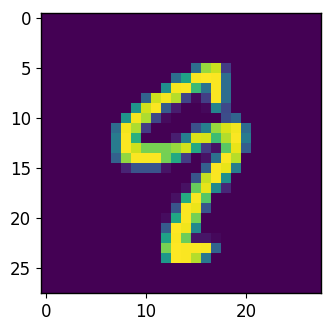

In [77]:
plt.imshow(X_batch[39])

In [78]:
y_batch[39]

1

In [79]:
X_batch[39].size

784